In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Get hydra config without initialization of hydra (except for hydra related ones)

import omegaconf

config = omegaconf.OmegaConf.load("configs/train.yaml")

In [5]:
from src.data import HistoDataset, HistoSampler
from torch.utils.data import DataLoader

import train

# Define debugging dataset
dataset = HistoDataset(
    file=config.data_path,
    mean=config.mean,
    std=config.std
)

# Overfit on one image only
debug_sampler = HistoSampler(
    file=config.data_path,
    tile_size=config.tile_size,
    epoch_length=config.train_epoch_size,
    sample_groups=['B02'],
    sample_images=['0000']
)

# Dataloader without workers
train.train_loader = DataLoader(
    dataset=dataset,
    batch_size=config.batch_size,
    sampler=debug_sampler,
    num_workers=config.num_workers
)

In [11]:
# Define model and training target

from src.vae import VariationalAutoencoder, Encoder, Decoder, VAELoss
import torch
import torch.nn as nn

# Keep model initialization fix
torch.manual_seed(299792458)

# Model
train.model = VariationalAutoencoder(latent_dim=config.latent_dim)
train.model.to(config.device)

# Optimizers specified in the torch.optim package
train.optimizer = torch.optim.Adam(train.model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

# Define reconstruction loss function
train.loss_function = VAELoss()

Use latent dim of 256


Task 1
---

Check the initial loss for your pipeline. Is it plausible?

Loaded debug batch of size torch.Size([64, 1, 128, 128])


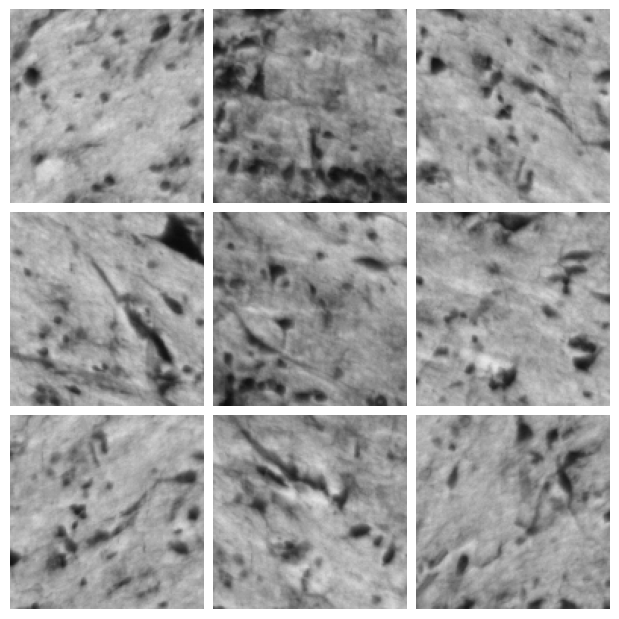

In [12]:
# Get a single batch and visualize it

from src.utils import show_tiles

torch.random.manual_seed(299792458)

debug_batch = next(iter(train.train_loader))
print(f"Loaded debug batch of size {debug_batch.shape}")

show_tiles(debug_batch[:9], mean=config.mean, std=config.std)

Loss of 516604.8125
Output mean: 0.18362825 Output std: 0.0075191045
Target mean: -0.05028876 Target std: 0.66173714


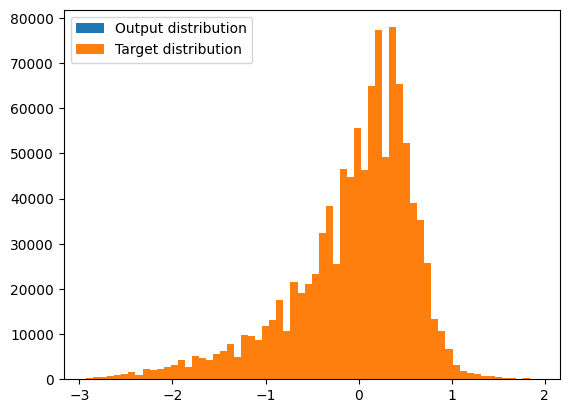

Example reconstruction of the network


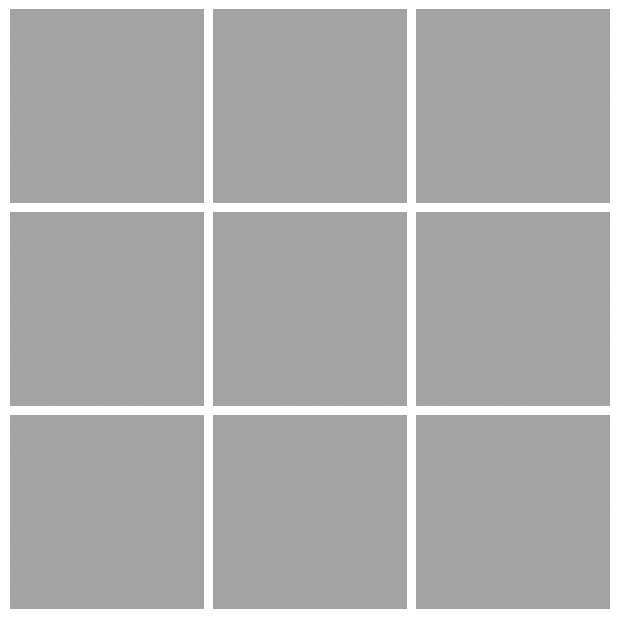

In [13]:
from src.utils import debug_stats

outputs = debug_stats(train.model, debug_batch, train.loss_function, config.device).cpu().numpy()

print("Example reconstruction of the network")
show_tiles(outputs[:9], mean=config.mean, std=config.std)

Task 2
---

Debug your training pipeline by training one epoch on a reduced training dataset (e.g. only two images per brain) until you observe a falling loss.

In [14]:
# Let the model overfit for one epoch
from train import train_one_epoch
import logging

# Hack the logging package to get info from the train loop for Jupyter notebooks
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("Enable logging")

# Train the model for one epoch
train.model.train(True)
avg_loss = train_one_epoch(
    epoch_index=0,
    tb_writer=None,
    log_interval=config.log_interval,
    device=config.device
)
train.model.train(False);

DEBUG:root:Enable logging
INFO:train:  batch 100 loss: 461153.67375
INFO:train:  batch 200 loss: 383710.6728125
INFO:train:  batch 300 loss: 354523.66625
INFO:train:  batch 400 loss: 326209.8465625
INFO:train:  batch 500 loss: 294770.2509375
INFO:train:  batch 600 loss: 276943.31265625
INFO:train:  batch 700 loss: 264813.17796875
INFO:train:  batch 800 loss: 251090.3578125
INFO:train:  batch 900 loss: 242241.07609375
INFO:train:  batch 1000 loss: 230282.7396875


Loss of 218100.46875
Output mean: -0.03415686 Output std: 0.49841285
Target mean: -0.05028876 Target std: 0.66173714


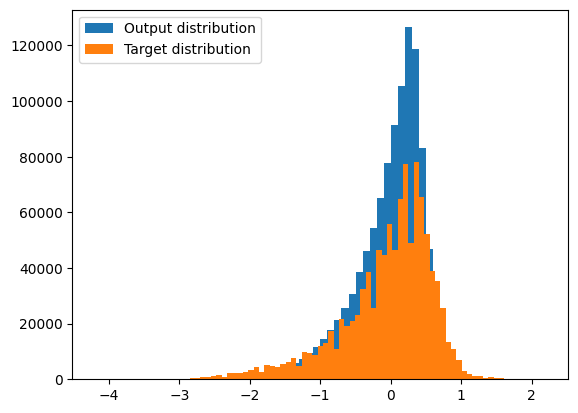

Example reconstruction of the network


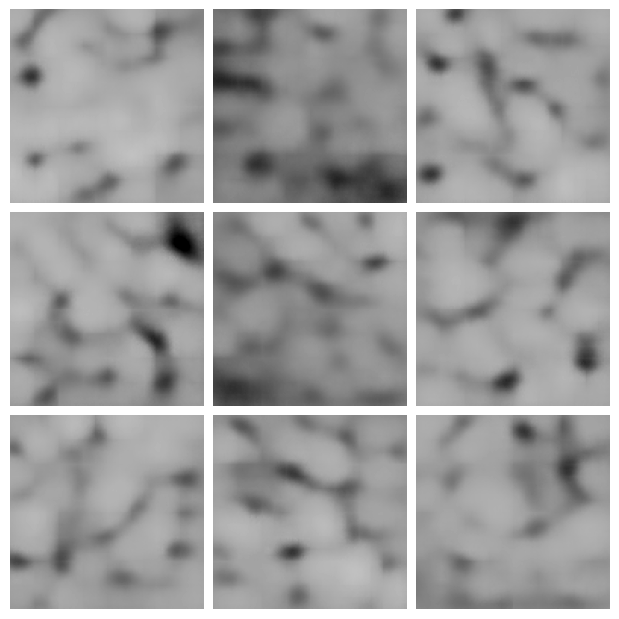

In [16]:
from src.utils import debug_stats

outputs = debug_stats(train.model, debug_batch, train.loss_function, config.device).cpu().numpy()

print("Example reconstruction of the network")
show_tiles(outputs[:9], mean=config.mean, std=config.std)

The target and output distributions resemble each other and the loss decreased. Ready for full data training!

Task 3
---

Train your model until convergence of the loss and store the paramters in a PyTorch State Dict

> Checkout `train.sh` and `train.py` for this